# <h1> Movie Recommendation System <img src="https://www.pngall.com/wp-content/uploads/13/Movie-Hollywood-No-Background.png" width=200 style="vertical-align: middle"> </h1> 

## **Introduction**
Our team has been tasked with designing a state-of-the-art recommendation system that leverages advanced data analysis techniques to enhance user engagement. The project focuses on two critical areas: hashing techniques to optimize data retrieval speed and clustering algorithms to group users based on shared movie preferences. 
By combining these approaches, we aim to deliver faster, more accurate, and highly personalized movie recommendations that align with individual tastes and behaviors.This project not only addresses the technical challenges of scalability and precision in recommendation systems but also paves the way for deeper insights into user behavior, enabling a more immersive and satisfying entertainment experience.

<h3> <b> Import Libraries </b> <img src="https://preview.redd.it/snoovatar/avatars/nftv2_bmZ0X2VpcDE1NToxMzdfZWI5NTlhNzE1ZGZmZmU2ZjgyZjQ2MDU1MzM5ODJjNDg1OWNiMTRmZV8yMTQ1NzYzNg_rare_46f1cdb1-634f-4c1d-8344-2be06c7880d4-headshot.png?width=256&height=256&crop=smart&auto=webp&s=400ead9440c7a9f06ca4c44953f24c5b765c4aac" width=150 style="vertical-align: middle"> </h3>

In [3]:
!pip install pandas numpy tqdm seaborn

import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Recommendation System with LSH

In this section, we will implement a recommendation system by identifying users with similar preferences and suggesting movies based on their behavior. Specifically, we will implement our version of the **LSH algorithm**.

## 1.1 Data Preparation

In [4]:
import os

directory_path = "/Users/ataberkfirat/Downloads/archive-2"

# Dizin içeriğini listeleme
files = os.listdir(directory_path)

print("Dizin içeriği:")
for file in files:
    print(file)

Dizin içeriği:
rating.csv
tag.csv
genome_scores.csv
genome_tags.csv
link.csv
movie.csv


In [13]:
# CSV dosyasını yükleme
csv_file_path = "/Users/ataberkfirat/Downloads/archive-2/rating.csv"
rating = pd.read_csv(csv_file_path)

print(rating.head())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


In [14]:
# Show the Rating Dataset informations
rating.info,rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


(<bound method DataFrame.info of           userId  movieId  rating            timestamp
 0              1        2     3.5  2005-04-02 23:53:47
 1              1       29     3.5  2005-04-02 23:31:16
 2              1       32     3.5  2005-04-02 23:33:39
 3              1       47     3.5  2005-04-02 23:32:07
 4              1       50     3.5  2005-04-02 23:29:40
 ...          ...      ...     ...                  ...
 20000258  138493    68954     4.5  2009-11-13 15:42:00
 20000259  138493    69526     4.5  2009-12-03 18:31:48
 20000260  138493    69644     3.0  2009-12-07 18:10:57
 20000261  138493    70286     5.0  2009-11-13 15:42:24
 20000262  138493    71619     2.5  2009-10-17 20:25:36
 
 [20000263 rows x 4 columns]>,
 None)

In [15]:
#Import the movie dataset with all movie title and genres
csv_file_path = "/Users/ataberkfirat/Downloads/archive-2/movie.csv"
movie = pd.read_csv(csv_file_path)

print(movie.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [16]:
# Define a function to obtain the film title without date
def splitter_title(text):
    text=text.split("(")
    return text[0]

In [17]:
# Apply the splitter_title function to the "title" column and store the result in "title2"
movie["title2"] = movie["title"].apply(splitter_title)

# Split the "genres" column by "|" and store the resulting list in "genre_list"
movie["genre_list"] = movie["genres"].str.split("|")

# Display the first 5 rows of the DataFrame to check the new columns
movie.head()

,movieId,title,genres,title2,genre_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,[Comedy]


### Why we use `map` instead of `merge`?

In this context, `map` is used because it is computationally more efficient for simple one-to-one mappings compared to `merge`. Here's why:

1. **Performance**:  
   `map` is faster when you need to map a single column based on a key-value relationship, as it avoids the overhead of merging entire DataFrames.

2. **Memory Usage**:  
   `map` consumes less RAM memory since it only operates on the relevant column and does not create a new DataFrame, unlike `merge`.



In [18]:
# Map 'title2' column to 'Movie Title'
rating["Movie Title"] = rating['movieId'].map(movie.set_index('movieId')['title2'])

# Map 'genre_list' column to 'Genre'
rating["Genre"] = rating['movieId'].map(movie.set_index('movieId')['genre_list'])

In [19]:
rating.head()

,userId,movieId,rating,timestamp,Movie Title,Genre
0,1,2,3.5,2005-04-02 23:53:47,Jumanji,"[Adventure, Children, Fantasy]"
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]"
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys,"[Mystery, Sci-Fi, Thriller]"
3,1,47,3.5,2005-04-02 23:32:07,Seven,"[Mystery, Thriller]"
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The","[Crime, Mystery, Thriller]"


In [20]:
# Show the new Rating Dataset informations
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   userId       int64  
 1   movieId      int64  
 2   rating       float64
 3   timestamp    object 
 4   Movie Title  object 
 5   Genre        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [21]:
# Check if there are NA values in the dataset

rating.isnull().sum()

userId         0
movieId        0
rating         0
timestamp      0
Movie Title    0
Genre          0
dtype: int64

### Information about the dataset

#### 1. **Time range and the number of movies released for each year**

In [22]:
# Convert the "timestamp" column to datetime format
rating["timestamp"] = pd.to_datetime(rating["timestamp"])

# Calculate the time range in years and print it with better formatting
time_range_years = rating["timestamp"].max().year - rating["timestamp"].min().year
print(f"The dataset covers a time range of {time_range_years} years, from {rating['timestamp'].min().year} to {rating['timestamp'].max().year}")

The dataset covers a time range of 20 years, from 1995 to 2015


In [23]:
# Define a new column with only year of timestamp column
rating['year'] = rating['timestamp'].dt.year

# Count unique movies per year
movies_per_year = rating.drop_duplicates(subset='Movie Title')['year'].value_counts().sort_index()

# Show the results
print(movies_per_year)

year
1996     331
1997     143
1998      99
1999     773
2000     485
2001     666
2002    1026
2003     548
2004     495
2005    1121
2006     512
2007    1267
2008     774
2009    1516
2010    1844
2011    2219
2012    2324
2013    2495
2014    3720
2015    2963
Name: count, dtype: int64


/var/folders/g_/_z1sv41j7xn_3zr27wjw3hd80000gn/T/ipykernel_26965/3439854290.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movies_per_year.index, y=movies_per_year.values, palette='viridis',edgecolor="black")


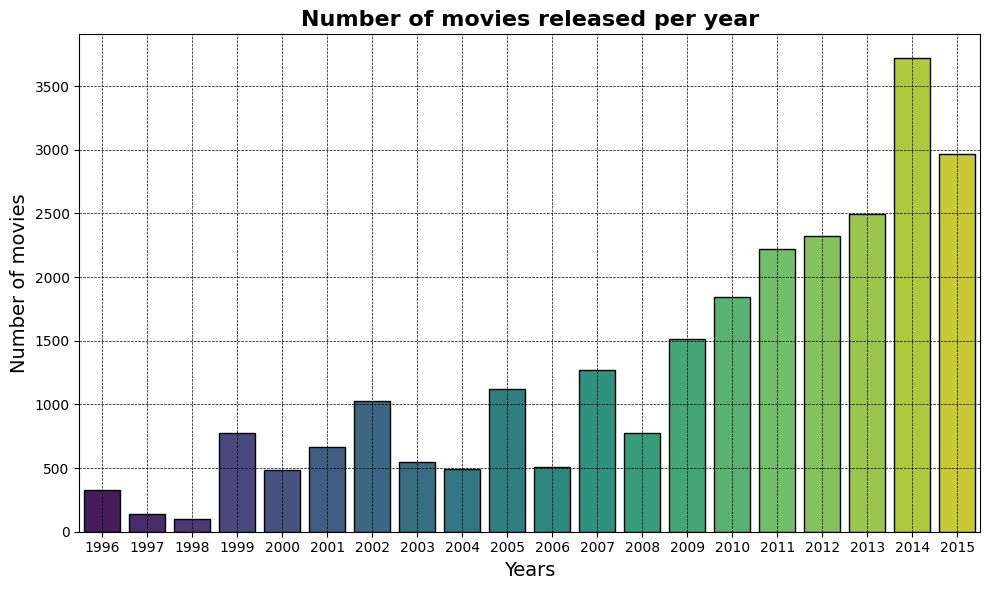

In [24]:
# Create a bar chart to see the number of movies released for each year

plt.figure(figsize=(10, 6))
sns.barplot(x=movies_per_year.index, y=movies_per_year.values, palette='viridis',edgecolor="black")  
plt.title('Number of movies released per year', fontsize=16, fontweight='bold')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Number of movies', fontsize=14)

plt.grid(linestyle='--',linewidth=0.5,color="black")
plt.tight_layout()
plt.show()

The graph shows a clear upward trend in the number of movies released per year, with a significant spike in 2014 reaching over 3,000 movies. The data suggests that the movie industry has experienced substantial growth and expansion over the past two decades, with an increasing number of films being produced and released annually.

#### 2. **Number of reviews per user**

In [25]:
# Group by 'userId', count the number of ratings each user has, and sort in descending order
user_rating_counts = rating.groupby('userId')['rating'].apply(len).sort_values(ascending=False)

# Print the results with clear labels
print(f"Top 5 users with the most ratings:\n{user_rating_counts.head(5)}")
print(f"\nBottom 5 users with the fewest ratings:\n{user_rating_counts.tail(5)}")

Top 5 users with the most ratings:
userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: rating, dtype: int64

Bottom 5 users with the fewest ratings:
userId
89305     20
110463    20
96990     20
134747    20
6526      20
Name: rating, dtype: int64


There are users who have watched more than 5000 different movies. Probably those who have watched so many movies are usually film critics, journalists or extremely dedicated film enthusiasts.

# 1.2.0 Minhash Signatures

This function will **hash** each user's watched movie list to create a **signature vector**, which provides a compact representation of the user's preferences. By using **MinHash**, we can generate these signature vectors based on the movies that each user has rated. The key advantage of using MinHash is that it allows for **quick comparisons** of user similarity without directly comparing their entire lists of movies.

### Steps:
1. **Hash User's Movie List**: For each user, we generate a hash based on their watched movies.
2. **MinHash Signatures**: The MinHash function creates a **signature vector** for each user, which is a compressed version of their movie list.
3. **Efficient Similarity Comparison**: These signature vectors make it faster to compare users, enabling quick identification of similar users based on their movie preferences.


In [26]:
# Group the 'rating' DataFrame by 'userId', then apply 'set()' to the 'movieId' for each user.
user_movies=rating.groupby('userId')['movieId'].apply(set).to_dict()
print("User Movies:")
for user, movies in list(user_movies.items())[:5]:  # Display the first 5 users
    print(f"User {user}: {movies}")

User Movies:
User 1: {2, 3081, 4105, 1036, 5146, 541, 29, 32, 4128, 4133, 47, 1584, 5679, 50, 5171, 2100, 1079, 1080, 1089, 1090, 2628, 2118, 1097, 589, 7757, 7247, 593, 3153, 2644, 2648, 2138, 2140, 2143, 6242, 6754, 6755, 2664, 112, 1136, 4720, 6774, 2683, 2173, 2174, 4226, 2692, 653, 2193, 2194, 4754, 151, 6807, 2716, 5797, 1193, 1196, 1198, 1200, 1201, 6834, 8368, 1208, 5816, 6333, 1214, 1215, 1217, 3265, 1219, 1222, 2761, 2762, 2253, 4306, 1750, 1240, 1243, 7387, 7389, 1246, 223, 1249, 6888, 1258, 1259, 1261, 1262, 2288, 1266, 2291, 2804, 253, 1278, 8961, 260, 5898, 1291, 4878, 7438, 1304, 7449, 7454, 4896, 8482, 293, 296, 1321, 4911, 3889, 4915, 1333, 1848, 2872, 7482, 8507, 318, 5952, 1348, 1350, 4941, 1358, 337, 7001, 1370, 3932, 1374, 4446, 2918, 6502, 1387, 3438, 367, 5999, 4467, 4980, 1920, 2944, 4993, 2947, 7045, 7046, 6539, 2959, 3476, 919, 2968, 3479, 924, 3996, 3997, 3489, 5026, 5540, 3499, 4011, 1967, 5039, 5040, 3000, 4027, 8636, 1994, 1997, 6093, 31696, 3030, 4571, 30

MinHash is a technique used for approximating the similarity between sets, such as the set of movies each user has watched in a recommendation system. It uses multiple hash functions to generate **signature vectors** that represent the set of movies a user has rated.

For the MinHash we defined three different type of Hash function. In details:

## The three Hash Functions:

### 1. **Linear Hash Function**
The **linear** hash function is the simplest type, using the formula:

$ Hash(x) = (a \cdot x + b) \mod p $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **x** is the movie ID.

The idea behind this hash function is to perform a linear transformation of the movie ID, and then take the result modulo p. This produces a unique integer for each movie, which is used to create the signature.

---

### 2. **Polynomial Hash Function**
The **polynomial** hash function works similarly to the linear function, but instead of a simple linear transformation, it applies polynomial powers to the movie ID. The formula is:

$ Hash(x) =  \sum_{i=0}^{n} c_i \cdot (x^i) \mod p $

Where:
- $\mathbf{c_{i}}$ are random coefficients for each power of x ;
- **p** is a prime number (for example 10513) ;
- **n** is the degree of the polynomial ;
- **x** is the movie ID.

In this case, the movie ID is raised to successive powers, with each term multiplied by a corresponding random coefficient. The sum is then taken modulo **p**.

---

### 3. **Universal Hash Function**
The **universal** hash function is a more advanced form of hashing that uses `double hashing` to reduce the probability of collisions in a hash table. The idea is to apply two hash functions and combine the results to get a more uniform distribution of hashes.
The second hash function applies an additional step using the value obtained from the first function ($ Hash_1(x) $ ) and a larger modulus m.

$ Hash_1(x) $ = $ ((a \cdot x + b) \mod p) $  

$ Hash_2(x) $ = $ ((a \cdot Hash_1(x) + b) \mod m) $  

$ Hash_{1,2}(x)=(Hash_1(x)+Hash_2(x)) \mod m $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **m** is the modulus used to limit the hash output to a specific range. It is generally a prime number larger than the modulus used in the first hash function to reduce the risk of collisions.

### MinHash Process:

1. **Random Coefficients** : For each hash function, random values a and b are generated within the range of the modulus p ;
   
2. **Hashing Process** : For each movie in the user's watched list, apply the formula \hash(x) for each hash function. This results in a unique integer value (hash) for each movie ;

3. **Signature Vector** : The minimum hash value for each of the hash functions is selected from the set of movie hashes. This set of minimum values across all hash functions forms the **signature vector** for the user.


In [27]:
from minhash_similarity import MinHash

# Show the informations about the two functions of the MinHash module:
help(MinHash)

Help on class MinHash in module minhash_similarity:

class MinHash(builtins.object)
 |  MinHash(n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |      Initialize MinHash with a specified number of hash functions.
 |      
 |      Args:
 |          n_hash_functions: Number of hash functions to use for creating signatures (default is 100)
 |          prime: A higher prime number for the hash function (default is 10513)
 |          type_function: Type of hash function to use ('linear', 'universal', 'polynomial')
 |  
 |  create_signature(self, movie_set)
 |      Create MinHash signature for a set of movies.
 |      
 |      Args:
 |          movie_set: Set of movie IDs
 |          
 |      Returns:
 |          np.ndarray: MinHash signature (array of minimum hash values)
 |  
 |  hash_function(self, x, a, b, i)

### **Minhash signatures and Jaccard Similarity**

In [29]:
from tqdm import tqdm

def generate_signatures(user_movies: dict, num_hash_function: int,function_name: str):

    minhash=MinHash(num_hash_function,type_function=function_name)
     # Initialize an empty dictionary to store the MinHash signatures for each user.
    signatures = {}

    # Iterate over each user and their associated movie set in the `user_movies` dictionary.
    # Use tqdm to display a progress bar for tracking the loop's progress.

    for user_id, movies in tqdm(user_movies.items(), desc="Generating Signatures", total=len(user_movies)):
        signatures[user_id] = minhash.create_signature(movies)   # Generate a MinHash signature for the current user's movie set and store it.
    return signatures

**Jaccard Similarity** (or Jaccard Index) is a statistical measure used to compare the similarity and diversity between two sets. It is commonly used to calculate the similarity between two sets of items, such as the sets of movies watched by two users in a recommendation system.

## Formula:

The formula to calculate Jaccard Similarity between two sets A and B is as follows:

$$\ J(A, B) = \frac{|A \cap B|}{|A \cup B|}\$$

Where:
- \|A $\cap B|$ is the **cardinality of the intersection** of A and B , the number of elements common to both sets.
- \|A $\cup B|$ is the **cardinality of the union** of  A and B , the total number of elements present in at least one of the two sets.


In [30]:
def exact_jaccard_similarity(sig1, sig2):
    """
    sig1 : the signature of the user 1
    sig2 : the signature of the user 2
    """
    intersection = len(sig1 & sig2)
    union = len(sig1 | sig2)
    return intersection / union # Return Jaccard similarity value between 0 and 1

### `compute_similarities` function

This function calculates Jaccard similarity between randomly sampled user pairs (1000 samples) to reduce computation time. Instead of comparing all users, it randomly selects a subset for similarity calculation using MinHash. 

Pairs with estimated Jaccard similarity above a given threshold (0.6) are considered similar.

- **Random Sampling:** 1000 random user pairs are selected ;
- **Thresholding:** Pairs with estimated similarity above the threshold are counted as similar ;
- **Outputs:** The function prints the most similar pairs, average loss and the count of similar/non-similar user pairs.

**Considerations**

We chose this sample size to evaluate whether the Jaccard similarities estimated by the algorithm align with the real Jaccard similarities of the users. Conducting a complete analysis involving all users would have required nearly 10 billion comparisons, making it hard computationally.


In [31]:
def compute_similarities(user_signatures, user_movies, max_results=10, similarity_threshold=0.6, hash_functions=100):
    # Initialize a counter to track the number of similar user pairs above the threshold
    similar_users_count=0
    # Set a random seed for reproducibility of results
    np.random.seed(213242)
    
    # Select 1000 random user IDs to compute similarities
    user_ids = np.random.choice(range(1, len(user_movies) + 1), 1000, replace=False)
    
    # Initialize dictionaries to store similarities and losses
    similarities, losses = {}, []
    
    for i in range(len(user_ids)):
        for j in range(i + 1, len(user_ids)):
        
            # Create MinHash instance for each comparison
            minhash = MinHash(n_hash_functions=hash_functions)
            
            # Estimate Jaccard similarity using MinHash signatures
            est_sim = minhash.jaccard_similarity(user_signatures[user_ids[i]], user_signatures[user_ids[j]])
            
            # Filter pairs above certain similarity threshold
            if est_sim > similarity_threshold:

                similar_users_count += 1  # Increment the counter for similar users

                # Compute exact Jaccard similarity
                exact_sim = exact_jaccard_similarity(user_movies[user_ids[i]], user_movies[user_ids[j]])
                
                # Calculate loss between estimated and exact similarities
                loss = abs(est_sim - exact_sim)
                losses.append(loss)
                
                # Store similarity information
                similarities[(user_ids[i], user_ids[j])] = (est_sim, exact_sim, loss)
    
    # Sort similarities by estimated similarity in descending order
    sorted_sims = sorted(similarities.items(), key=lambda x: x[1][0], reverse=True)[:max_results]
    
    # Print details of top similar user pairs
    for (user1, user2), (est_sim, exact_sim, loss) in sorted_sims:
        print(f"Users: ({user1}, {user2}) --> Estimated: {est_sim:.2f}, Exact: {exact_sim:.2f}, Loss: {loss:.2f}")
    
    # Calculate average loss
    avg_loss = np.mean(losses) 
    print(f"\nAverage Loss: {avg_loss:.4f}")
    print(f"\nNumber of similar user pairs (estimated similarity > {similarity_threshold}): {similar_users_count}, Number of non similar user pairs is {1000-similar_users_count}")
  

In [32]:
# Print and generate signatures with different types of hash functions and 50 hash functions

# Using Linear hash functions

print("Generating signatures with Linear hash function --> 50 hash functions:")
signatures_linear_50 = generate_signatures(user_movies, 50 , function_name='linear')
print("-" * 80)

# Using Universal hash functions

print("Generating signatures with Universal hash function --> 50 hash functions:")
signatures_universal_50 = generate_signatures(user_movies, 50 , function_name='universal')
print("-" * 80)

# Using Polynomial hash functions

print("Generating signatures with Polynomial hash function --> 50 hash functions:")
signatures_polynomial_50 = generate_signatures(user_movies, 50 , function_name='polynomial')


Generating signatures with Linear hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [05:32<00:00, 416.17it/s]


--------------------------------------------------------------------------------
Generating signatures with Universal hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [07:59<00:00, 288.64it/s] 


--------------------------------------------------------------------------------
Generating signatures with Polynomial hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [16:11<00:00, 142.58it/s]


<h4> Now we compute the similarities for the three Hash Functions using the previously defined function for each set of signatures with a different number of hash functions </h4>
 

In [33]:
# 1. Linear
print("Similarities with Linear Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_linear_50, user_movies, hash_functions=50))

Similarities with Linear Hash Function --> 50 Hash Functions:
Users: (93094, 50559) --> Estimated: 0.88, Exact: 0.68, Loss: 0.20
Users: (92201, 19488) --> Estimated: 0.84, Exact: 0.62, Loss: 0.22
Users: (2028, 41335) --> Estimated: 0.82, Exact: 0.83, Loss: 0.01
Users: (92201, 17104) --> Estimated: 0.82, Exact: 0.67, Loss: 0.15
Users: (26219, 35593) --> Estimated: 0.80, Exact: 0.84, Loss: 0.04
Users: (25173, 35593) --> Estimated: 0.80, Exact: 0.69, Loss: 0.11
Users: (18916, 97084) --> Estimated: 0.76, Exact: 0.68, Loss: 0.08
Users: (18916, 41335) --> Estimated: 0.74, Exact: 0.82, Loss: 0.08
Users: (132685, 26219) --> Estimated: 0.72, Exact: 0.71, Loss: 0.01
Users: (132685, 99578) --> Estimated: 0.72, Exact: 0.66, Loss: 0.06

Average Loss: 0.0698

Number of similar user pairs (estimated similarity > 0.6): 38, Number of non similar user pairs is 962
None


In [34]:
# 2. Universal
print("Similarities with Universal Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_universal_50, user_movies, hash_functions=50))

Similarities with Universal Hash Function --> 50 Hash Functions:
Users: (26219, 35593) --> Estimated: 0.86, Exact: 0.84, Loss: 0.02
Users: (17104, 19488) --> Estimated: 0.78, Exact: 0.65, Loss: 0.13
Users: (18916, 41335) --> Estimated: 0.76, Exact: 0.82, Loss: 0.06
Users: (42267, 64287) --> Estimated: 0.76, Exact: 0.72, Loss: 0.04
Users: (2028, 41335) --> Estimated: 0.74, Exact: 0.83, Loss: 0.09
Users: (132685, 99578) --> Estimated: 0.74, Exact: 0.66, Loss: 0.08
Users: (18916, 97084) --> Estimated: 0.72, Exact: 0.68, Loss: 0.04
Users: (41335, 35593) --> Estimated: 0.72, Exact: 0.69, Loss: 0.03
Users: (25173, 35593) --> Estimated: 0.72, Exact: 0.69, Loss: 0.03
Users: (15938, 35593) --> Estimated: 0.72, Exact: 0.71, Loss: 0.01

Average Loss: 0.0597

Number of similar user pairs (estimated similarity > 0.6): 36, Number of non similar user pairs is 964
None


In [35]:
# 3. Polynomial 
print("Similarities with Polynomial Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_polynomial_50, user_movies, hash_functions=50))

Similarities with Polynomial Hash Function --> 50 Hash Functions:
Users: (2028, 41335) --> Estimated: 0.78, Exact: 0.83, Loss: 0.05
Users: (18916, 41335) --> Estimated: 0.78, Exact: 0.82, Loss: 0.04
Users: (26219, 35593) --> Estimated: 0.78, Exact: 0.84, Loss: 0.06
Users: (92201, 17104) --> Estimated: 0.74, Exact: 0.67, Loss: 0.07
Users: (132685, 26219) --> Estimated: 0.74, Exact: 0.71, Loss: 0.03
Users: (92201, 19488) --> Estimated: 0.72, Exact: 0.62, Loss: 0.10
Users: (25173, 35593) --> Estimated: 0.72, Exact: 0.69, Loss: 0.03
Users: (132685, 35593) --> Estimated: 0.70, Exact: 0.69, Loss: 0.01
Users: (15938, 35593) --> Estimated: 0.70, Exact: 0.71, Loss: 0.01
Users: (134604, 33207) --> Estimated: 0.68, Exact: 0.61, Loss: 0.07

Average Loss: 0.0629

Number of similar user pairs (estimated similarity > 0.6): 27, Number of non similar user pairs is 973
None


# MinHash Similarity Comparison

---

### 1. **Linear Hash Function (50 Hash Functions)**
   - The Linear Hash Function demonstrates the **lowest average loss** among the three. This indicates that its similarity estimates are consistently close to the true values. 
   - Given its balance between precision and computational efficiency, it is the **best choice** for  applications requiring a good trade-off between accuracy and processing time.

---

### 2. **Universal Hash Function (50 Hash Functions)**
   - The universal hash function has a **computational complexity similar to the linear**. In the tests conducted, **the average loss is unstable**, in most cases it was the slightly higher one among the other functions with a loss of 0.1 although it can also reach a lower loss.
---

### 3. **Polynomial Hash Function (50 Hash Functions)**
   - The polynomial hash function shows a **relatively low average loss**, but it is the **most computationally expensive** among the three. It is a good alternative when higher precision is needed, but with a higher computational cost respect linear.
---

### **Conclusion**
   - The Linear Hash Function is the best choice, with the lowest average loss and good computational performance.


<h3> To further improve the similarity and reduce the average loss, we increase the number of Hash functions for the linear. </h3>

In details:
- We define signatures for each user id with a higher number of Hash functions (100,200). We expect that higher number of functions will lead to higher computational cost but very high accuracy ;
- We calculate the estimated Jaccard with 100,200 Hash functions and observe the differences from the exact Jaccard between different users ;
- Let's compare the results by looking at the average loss calculated on a random sample of 1000 users as a metric ;

In [36]:
# Let's try with 100 and 200 functions to see if the avg loss will be lower

# The length of the signature increases further, improving the similarity
signatures_linear_100 = generate_signatures(user_movies, 100,function_name='linear')

print("-" * 80)

# Much more detailed signature, suitable for the scenario where high precision is needed
# It is the most expensive in terms of memory and computation.
signatures_linear_200 = generate_signatures(user_movies, 200,function_name='linear')

Generating Signatures: 100%|██████████| 138493/138493 [11:11<00:00, 206.12it/s]


--------------------------------------------------------------------------------


Generating Signatures: 100%|██████████| 138493/138493 [22:23<00:00, 103.08it/s]


<h3> Compare similarity for 100-200 number of Hash Functions </h3>

In [37]:
print("Similarities with 100 Hash Functions:")
print(compute_similarities(signatures_linear_100,user_movies,hash_functions=100))

print("-" * 80)

print("Similarities with 200 Hash Functions:")
print(compute_similarities(signatures_linear_200,user_movies,hash_functions=200))

Similarities with 100 Hash Functions:
Users: (26219, 35593) --> Estimated: 0.81, Exact: 0.84, Loss: 0.03
Users: (18916, 41335) --> Estimated: 0.78, Exact: 0.82, Loss: 0.04
Users: (2028, 41335) --> Estimated: 0.75, Exact: 0.83, Loss: 0.08
Users: (42267, 64287) --> Estimated: 0.75, Exact: 0.72, Loss: 0.03
Users: (41335, 35593) --> Estimated: 0.74, Exact: 0.69, Loss: 0.05
Users: (91064, 50559) --> Estimated: 0.73, Exact: 0.66, Loss: 0.07
Users: (41335, 97084) --> Estimated: 0.72, Exact: 0.68, Loss: 0.04
Users: (93094, 50559) --> Estimated: 0.71, Exact: 0.68, Loss: 0.03
Users: (92201, 17104) --> Estimated: 0.71, Exact: 0.67, Loss: 0.04
Users: (18916, 97084) --> Estimated: 0.70, Exact: 0.68, Loss: 0.02

Average Loss: 0.0457

Number of similar user pairs (estimated similarity > 0.6): 34, Number of non similar user pairs is 966
None
--------------------------------------------------------------------------------
Similarities with 200 Hash Functions:
Users: (2028, 41335) --> Estimated: 0.90, E

# 1.3.0 Locality-Sensitive Hashing (LSH)

Our approach leverages Locality-Sensitive Hashing (LSH) with 200 hash functions to efficiently compute user similarities at scale. By generating compact signatures for each user, we dramatically reduce computational complexity from O(n²) to near-linear time.

Key implementation details:

1. 200 hash functions create robust user signatures
2. Low average loss ensures high-quality similarity detection

The LSH model transforms the Jaccard similarity computation among the 138,000 users of the dataset, reducing the complexity from O(n²) to O(num_bands $\cdot$ rows_per_band + k) where:
- **num_bands** is the number of bands the signature is divided into ;
- **rows_per_band** is the number of rows per band (i.e., the length of each portion of the signature) ;
- **k** is the number of candidate users found in the same matching buckets.

This approach enables efficient analysis of the large-scale user network by minimizing computational overhead, preserving similarity patterns, and converting numerous pairwise comparisons into a fast approximation linear method.

**Bucket Creation:** For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

In [38]:
from locality_sensitive_hashing import LSH
help(LSH)

Help on class LSH in module locality_sensitive_hashing:

class LSH(builtins.object)
 |  LSH(num_bands: int, rows_per_band: int)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_bands: int, rows_per_band: int)
 |      Initialize the Locality Sensitive Hashing (LSH) object.
 |      
 |      Args:
 |          num_bands (int): Number of bands to divide signatures into.
 |          rows_per_band (int): Number of rows (hash values) in each band.
 |  
 |  build_buckets(self, signatures: dict)
 |      Build hash buckets by dividing signatures into bands.
 |      
 |      This method populates the buckets with user IDs that have similar 
 |      signature bands. It helps in quickly finding similar items by 
 |      reducing the search space.
 |      
 |      Args:
 |          signatures (dict): Dictionary with user IDs as keys and signature arrays as values.
 |      Returns:
 |              None
 |  
 |  create_bucket_hash(self, band_idx, band_signature)
 |      Create a hash that gen

### Optimal number of Bands and Rows for 200 Hash Functions

Given a signature matrix with **200 hash functions**, the total number of rows \( n \) is fixed at 200. The number of **bands (b)** and **rows per band (r)** must satisfy the equation:

$ n = b \times r $

---

#### Choosing the optimal numbers of bands and rows per band
  **Balance False Positives and False Negatives:**  
   - Fewer bands (b) and more rows per band (r) reduce false positives but increase false negatives;
   - More bands and fewer rows per band reduce false negatives but increase false positives.

We chose **10 bands** \( b = 10 \) and **20 rows per band** \( r = 20 \). Using fewer bands reduces the computational cost compared to configurations with more bands, while 20 rows per band ensures enough to reduce the impact of noise in the hash signatures.



In [39]:
# Initialize LSH with 20 bands, 10 rows per band
lsh_model = LSH(num_bands=20, rows_per_band=10)
    
# Build buckets from signatures with 200 hash functions
lsh_model.build_buckets(signatures_linear_200)

1. **Bucket Creation**: For each user, we divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets;

2. **Debug** : After creating buckets, we check bucket contents to verify that multiple users are being grouped in the same buckets.

In [40]:
# .view_buckets of LSH class show 10 random buckets and their respect contents
lsh_model.view_buckets()

Bucket LSH-378059: [32476, 40287, 70852]
Bucket LSH-505858: [33153, 65503, 94930]
Bucket LSH-529988: [101264]
Bucket LSH-301846: [37609, 85356, 91064, 97377, 108985]
Bucket LSH-312160: [3997]
Bucket LSH-718659: [5510, 80661]
Bucket LSH-188369: [5295, 62906, 77740, 132561]
Bucket LSH-306345: [542, 117684, 131831, 136302]
Bucket LSH-139555: [7028, 47416, 102840, 108894]
Bucket LSH-505658: [10589, 12051, 57355, 92276, 113758]


<h3> <strong> Query: </strong> for a given user, identify the two most similar users based on their bucket placement </h3>


In [41]:
import random

# Randomly select a user ID
user_id = random.randint(1, len(user_movies))

# Get the query user's signature
query_signature = signatures_linear_200[user_id]

# Query for similar users using LSH
similar_users = lsh_model.query(query_signature, user_id)

# Sort the similar users by exact Jaccard similarity in descending order
similar_users = sorted(similar_users, key=lambda x: exact_jaccard_similarity(signatures_linear_200[user_id], signatures_linear_200[x]), reverse=True)

# Get the top 2 most similar users
top_2_similar_users = similar_users[:2]

print(f"The two most similar users of user {user_id} are: {top_2_similar_users}")

The two most similar users of user 78369 are: [77441, 107523]


<h3> <strong> Movie Recommendation Logic </strong> </h3>


1. If both similar users have rated a movie, recommend this movie based on the average rating ;

2. If there are no commonly rated movies, recommend the top-rated movies of the most similar user ;

3. Final Recommendation: Provide at most five movies to the user.

In [42]:
# Filter the dataset by the two users similar to the query user ID
filtered_ratings=rating[["userId","Movie Title","rating"]].loc[rating["userId"].isin(top_2_similar_users)]
filtered_ratings

,userId,Movie Title,rating
11209476,77441,Heat,3.5
11209477,77441,"Usual Suspects, The",4.5
11209478,77441,Interview with the Vampire: The Vampire Chroni...,4.0
11209479,77441,Léon: The Professional,4.0
11209480,77441,Pulp Fiction,4.5
11209481,77441,"Shawshank Redemption, The",5.0
11209482,77441,"Silence of the Lambs, The",4.0
11209483,77441,"Rock, The",3.5
11209484,77441,Reservoir Dogs,4.0
11209485,77441,Groundhog Day,4.0


In [45]:
# Find movies rated by both similar users

movies_rated_by_similar_users = filtered_ratings.groupby('Movie Title').filter(lambda x: len(x['userId'].isin(top_2_similar_users)) == 2)

# Calculate average ratings for commonly rated movies
average_ratings = movies_rated_by_similar_users.groupby('Movie Title')['rating'].mean()

# Count the number of common movies to determine recommendation strategy
num_movies=len(average_ratings)

if average_ratings.empty:
    # If no common movies, find the top-rated movies by each similar user
    top_rated_by_user = filtered_ratings.loc[filtered_ratings.groupby('userId')['rating'].idxmax()]
    print("No common movies rated by both users. Here are the top ratings per user:")
    print(top_rated_by_user)
    num_movies=2 
else:
    # Print the top 5 common movies with their average ratings
    print("Common movies rated by both similar users:")
    for movie, avg_rating in average_ratings.nlargest(5).items():  # Provide at most five movies to the user
        print(f"Common Movie: {movie} (average rating: {avg_rating:.2f})")

# Supplementary strategy if fewer than 5 common movies are found, complete the list using other high-rated movies by the most similar users.
if num_movies < 5:
     # Exclude the movies that have been rated the highest by each user
    filtered_ratings_excluded = filtered_ratings[~filtered_ratings['Movie Title'].isin(top_rated_by_user['Movie Title'])]
    # Calculate how many more movies are needed to reach 5
    remaining_movies = 5 - num_movies
     # Get the top-rated movies (by each user) from the remaining movies after exclusion
    top_rated_by_user = filtered_ratings_excluded.loc[filtered_ratings_excluded.groupby('Movie Title')['rating'].idxmax()].sort_values('rating', ascending=False)

    print(f"Since there are only {num_movies} common movies, showing the top-rated movies from each user:")
    
    for index in range(remaining_movies):
        user_id, movie_title = list(dict(top_rated_by_user).keys())[index] 
        rating = list(dict(top_rated_by_user).values())[index]
        print(f"User {user_id} gave a rating of {rating:.2f} to the movie '{movie_title}'.")

Common movies rated by both similar users:
Common Movie: American Beauty  (average rating: 4.25)
Common Movie: Chocolat  (average rating: 3.00)


NameError: name 'top_rated_by_user' is not defined